## Analog randomized benchmarking for bosonic $d$ dimensional systems with $n$ particles

In [7]:
import numpy as np
from analogrb.gatefactory import UniformNNHGateFactory
from analogrb.channel import DepolarizingChannel
from analogrb.bosonic import OnsideIntNNHamiltonian, NonintNNHamiltonian

# number of nodes.
d = 3
# number of particles.
n = 2
# the y dimension of the lattice.
ydim = d
# Set if the system is interacting or not.
interacting_gates = False
# Build the Hamiltonian with which the system will be time evolved.
Hamiltonian = OnsideIntNNHamiltonian(d, n, ydim) if interacting_gates else NonintNNHamiltonian(d, n, ydim)
# The evolution time of the Hamiltonian
time = 1.
# When called, returns a random unitary, here a unitary from a uniformly drawn NN = nearest neighbour Hamiltonian. 
gatefactory = iter(UniformNNHGateFactory(Hamiltonian, time = time))
# The initial quantum state, here the |0x0| density matrix.
rho_init = np.zeros((Hamiltonian.fock_dim, Hamiltonian.fock_dim), dtype=np.complex128)
rho_init[0, 0] = 1.

# Set the error channel.
depol_param = 0.05
error_channel = DepolarizingChannel(depol_param)

# Set the parameters to run the arb protocol. ms are the depths of the quenches.
ms = [5,10, 15]
# How many time the protocol is repeated.
naverage = 10

# Set the statistical analysis paramters. 
nbootstraps = 100
confidence = 95

save = True

The Hamiltonian is a symbolic object which entries can be set randomly. This is a nearest neighbour Hamiltonian.

In [8]:
Hamiltonian.show()

Matrix([
[                 2*h11,            sqrt(2)*h12,              0,                      0,                      0,           0],
[sqrt(2)*conjugate(h12),              h11 + h22,            h23,            sqrt(2)*h12,                      0,           0],
[                     0,         conjugate(h23),      h11 + h33,                      0,                    h12,           0],
[                     0, sqrt(2)*conjugate(h12),              0,                  2*h22,            sqrt(2)*h23,           0],
[                     0,                      0, conjugate(h12), sqrt(2)*conjugate(h23),              h22 + h33, sqrt(2)*h23],
[                     0,                      0,              0,                      0, sqrt(2)*conjugate(h23),       2*h33]])

The data is stored in different .txt files for each single run:
* m (the depths $m$)
* U (the overall product unitary $U$)
* outcomes (the simulated experimental outcomes of the density matrix)

In [9]:
from analogrb.arb_protocol import simulate_data_acquisition

data_path = simulate_data_acquisition(d, n, interacting_gates, ms, gatefactory, rho_init, error_channel, naverage, save)

meta data saved to  /Users/jadwigawilkens/Physics/analog rb/analogrb/arbdata/3d_2n_nonint/sim-24-01-16-190717/metadata.json
1 out of 10 repetitions done
2 out of 10 repetitions done
3 out of 10 repetitions done
4 out of 10 repetitions done
5 out of 10 repetitions done
6 out of 10 repetitions done
7 out of 10 repetitions done
8 out of 10 repetitions done
9 out of 10 repetitions done
10 out of 10 repetitions done


When the data is stored, it has to be loaded again. The post processing adds the filtered values $q$ for each irrep, the values are normalized already.

In [10]:
import pandas as pd
from analogrb.arb_protocol import post_processing
from analogrb.save_load import extract_from_data
from analogrb.bootstrap import fit_with_bootstrap

data = post_processing(path = data_path)
# Turn into a pandas dataframe to analyze the data easier.
df = pd.DataFrame(data)
# Extract the names of the irreps for the different decay curves for each irrep.
names = [key for key in df.keys() if key.startswith("q_")]
# Initialize a new data frame to store the results.
df_result = pd.DataFrame(columns=['m', 'avg', 'yerr', 'popt', 'pcov'], index=names)
# Go through all the irrep data.
for name in names:
    ms, qs = extract_from_data(df, name, 'm', list)
    df_result.loc[name] = fit_with_bootstrap(ms, qs, nbootstraps, confidence)

The result dataframe now carries the whole analytical results from the given data acquired in the simulations process and the post processing.
<b>
for example the smaller irrep 

In [11]:
print('The result data for the smaller irrep.')
print(df_result.loc['q_2-1-0'])
print('The depth values:')
print(df_result.loc['q_2-1-0', 'm'])
print('And the averages of the qs:')
print(df_result.loc['q_2-1-0', 'avg'])

The result data for the smaller irrep.
m                                             [5, 10, 15]
avg     [1.0169640332064696, 0.8920659331714372, 0.470...
yerr    [[0.5502652906804559, 0.3367909085376961, 0.14...
popt             [1.4673498603646393, 0.9373417565101679]
pcov    [[0.8733972920769177, 1.932016140013981], [0.0...
Name: q_2-1-0, dtype: object
The depth values:
[ 5 10 15]
And the averages of the qs:
[1.0169640332064696, 0.8920659331714372, 0.4703644584031105]


Plot the result.

irrep 2-1-0 popt: A, p = [1.46734986 0.93734176]
irrep 4-2-0 popt: A, p = [2.11613536 0.90000155]


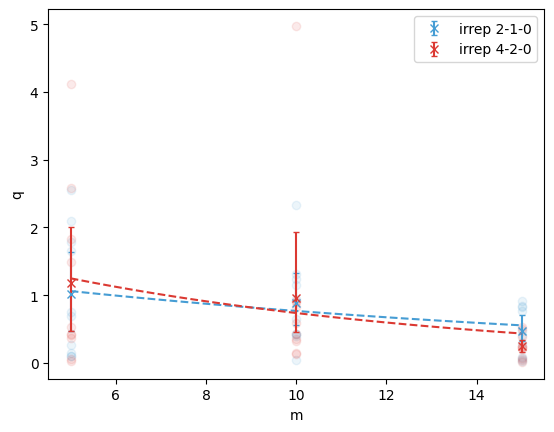

In [12]:
import matplotlib.pyplot as plt
from analogrb.save_load import extract_from_data
from analogrb.arb_protocol import EXP_FUNC

COLORS = ['#469DD4', '#DB3932', '#638537',  '#853763',  '#D79B00'] # blue, red, green, purple, orange


for k, name in enumerate(names):
    ms, qs = extract_from_data(df, name, 'm', list)
    color = COLORS[k]
    plt.scatter(*extract_from_data(df, name, 'm'), alpha=0.1, color=color)
    ms = df_result.loc[name, 'm']
    plt.errorbar(ms, df_result.loc[name, 'avg'], yerr=df_result.loc[name, 'yerr'], fmt='x', capsize=2, color=color, label=f"irrep {name[2:]}")
    ms_finespaced = np.linspace(np.min(ms), np.max(ms), len(ms)*20)
    plt.plot(ms_finespaced, EXP_FUNC(ms_finespaced, *df_result.loc[name, 'popt']), '--', color = color)
    print(f"irrep {name[2:]} popt: A, p = {df_result.loc[name, 'popt']}")
plt.ylabel('q')
plt.xlabel('m')
plt.legend()
plt.show()
